In [7]:

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning:

Config option `use_jedi` not recognized by `IPCompleter`.



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
pip install keras-tcn

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
!pip install chart_studio
import plotly.graph_objs as go

import chart_studio.plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
df_fake = pd.read_csv('/content/drive/My Drive/mydatasets/fake_news/Fake.csv', header=0)
df_true = pd.read_csv('/content/drive/My Drive/mydatasets/fake_news/True.csv', header=0)
df_fake['label'] = ['Fake' for x in range(0,len(df_fake))]
df_true['label'] = ['True' for x in range(0,len(df_true))]

In [12]:
df_fake.head()
df_true.head()
df = pd.concat([df_fake,df_true]) 

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [13]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [14]:
df.groupby('label').count()['text']

label
Fake    23481
True    21417
Name: text, dtype: int64

In [15]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['text'] = df['text'].apply(clean_text)

In [16]:
df = df.drop_duplicates(subset={"text"}, keep='first', inplace=False)

In [17]:
df['text'] = df['text'].str.replace('\d+', '')

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 208704 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (38616, 250)


In [21]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (38616, 2)


In [22]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y=df['label']
binarizedLabels = lb.fit_transform(Y)  

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X,binarizedLabels, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(34754, 250) (34754, 1)
(3862, 250) (3862, 1)


In [25]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

def define_model(kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [27]:
# Define the input shape
model = define_model(input_dim=len(word_index)+1, max_length=X.shape[1])

# Train the model
history = model.fit(X_train, Y_train, batch_size=50, epochs=10, verbose=1, validation_data=(X_test,Y_test))

Epoch 1/10
696/696 [==============================] - 1152s 2s/step - loss: 0.1240 - accuracy: 0.9392 - val_loss: 0.0243 - val_accuracy: 0.9909
Epoch 2/10
696/696 [==============================] - 1159s 2s/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0453 - val_accuracy: 0.9871
Epoch 3/10
696/696 [==============================] - 1151s 2s/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0183 - val_accuracy: 0.9943
Epoch 4/10
696/696 [==============================] - 1155s 2s/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0282 - val_accuracy: 0.9940
Epoch 5/10
696/696 [==============================] - 1153s 2s/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0345 - val_accuracy: 0.9920
Epoch 6/10
696/696 [==============================] - 1152s 2s/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0259 - val_accuracy: 0.9948
Epoch 7/10
696/696 [==============================] - 1155s 2s/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0368 - val_accuracy:

In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

121/121 [==============================] - 23s 194ms/step - loss: 0.0492 - accuracy: 0.9948
Test set
  Loss: 0.049
  Accuracy: 0.995


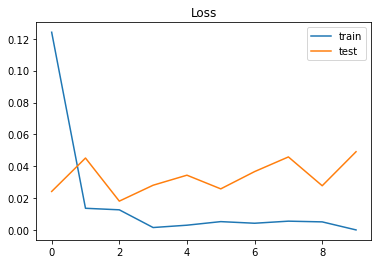

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

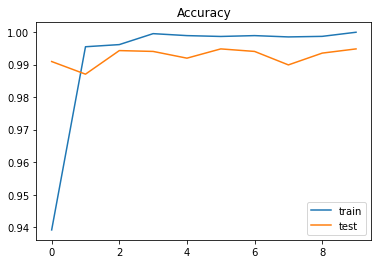

In [30]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [32]:
from sklearn.metrics import classification_report
def myfunc(a):
  return lb.classes_[a]
y_predz = model.predict(X_test, batch_size=50, verbose=1)
y_pred = (y_predz > 0.5) * 1
y_pred = y_pred.reshape(Y_test.shape)
predicted_Labels = map(myfunc, y_pred)
print(classification_report(list(lb.inverse_transform(Y_test))[:],list(lb.inverse_transform(y_pred))[:]))

78/78 [==============================] - 23s 292ms/step
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      1727
        True       0.99      1.00      1.00      2135

    accuracy                           0.99      3862
   macro avg       1.00      0.99      0.99      3862
weighted avg       0.99      0.99      0.99      3862



In [33]:
def plot_confusion_matrix(y_actual, y_pred):
    '''
    This method plots confusion matrix.
    '''
    classes = ['Fake News', 'Real News']
    tick_marks = np.arange(len(classes))

    accuracy = accuracy_score(y_actual, y_pred)
    print("Accuracy score:", "{:2.3}".format(accuracy))

    conf_matrix = confusion_matrix(y_actual, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    
    plt.tight_layout()
    plt.xticks(tick_marks , classes, rotation=0)
    plt.yticks(tick_marks , classes)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

Accuracy score: 0.995


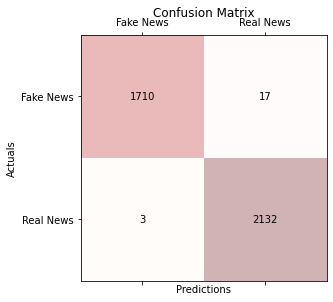

In [35]:
# plot confusion matrix on test
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
plot_confusion_matrix(list(lb.inverse_transform(Y_test))[:], list(lb.inverse_transform(y_pred))[:])



---

